<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/autoCorrTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.special import logit
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dependence variable
odr = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv')
odr = odr.query("Segment == 'CU'") #Select only one segment
odr = odr.eval("ODR = Bad / N") #ODR Calculation (12-Motnhs bad rate)

# Dependence variable transformation
# Logit transformation
y = logit(odr['ODR'])

# Import macroeconomics data (Independence variables)
mev = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv')

# Select variables for linear regression model
selectedVars = ['GDP_C_lg12', 'MPI_C_lg12']
X = sm.add_constant(mev[selectedVars]) #Add intercept

# Linear regression model
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.68
Date:                Thu, 16 Dec 2021   Prob (F-statistic):           6.99e-15
Time:                        13:16:05   Log-Likelihood:                 100.82
No. Observations:                  59   AIC:                            -195.6
Df Residuals:                      56   BIC:                            -189.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9473      0.019   -155.761      0.0

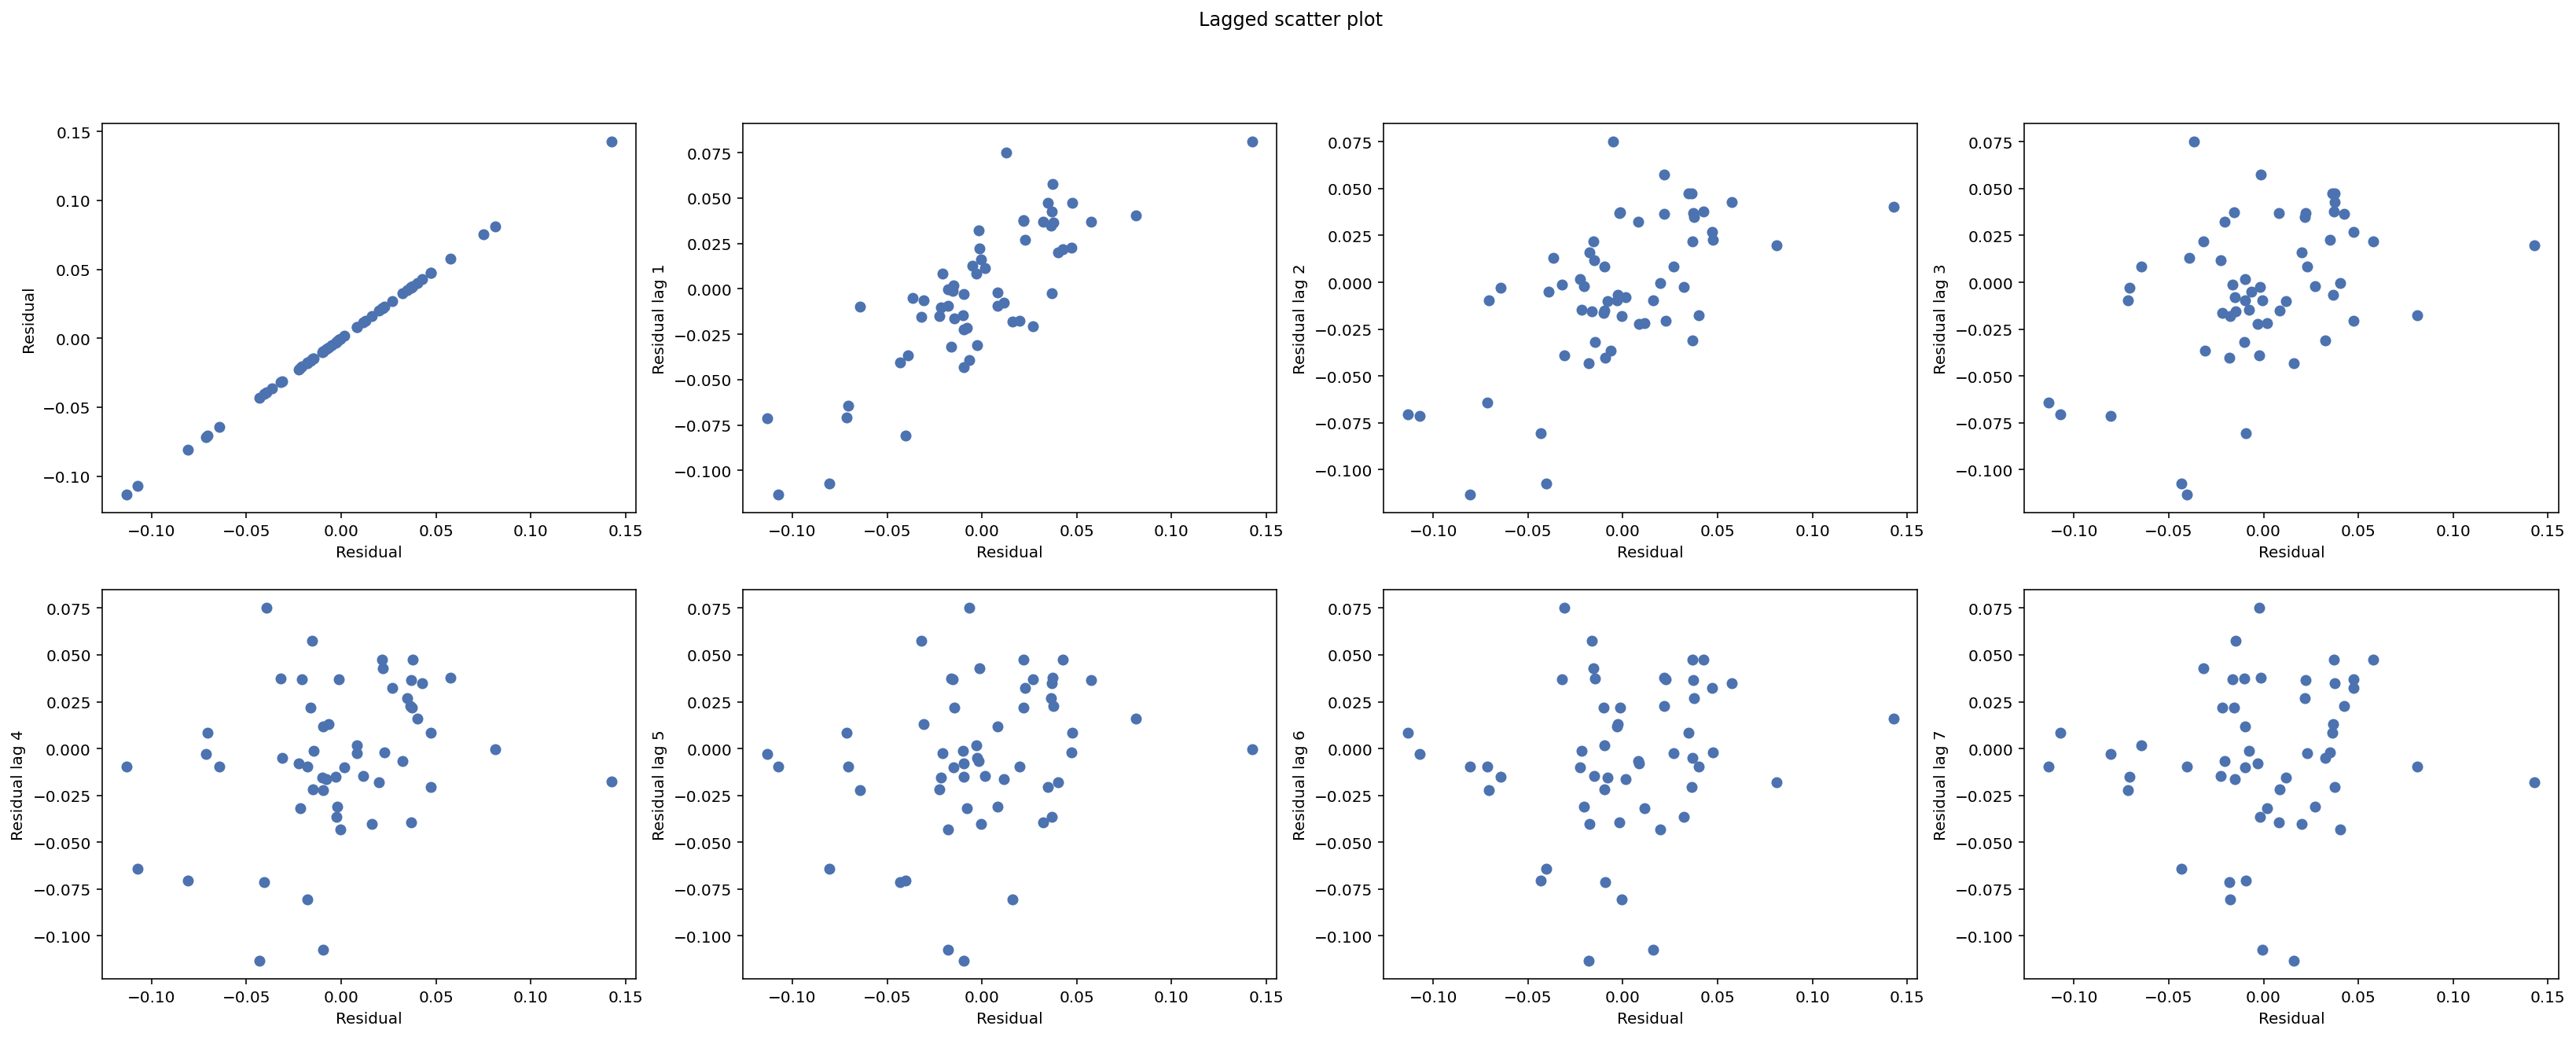

In [3]:
# Scatter plot
with plt.style.context('seaborn-deep'):
  fig, axs = plt.subplots(2, 4, figsize = (28, 10))
  fig.suptitle('Lagged scatter plot')
  axs = axs.ravel()
  for i in range(8):
    axs[i].scatter(x = result.resid,
                   y = result.resid.shift(i))
    axs[i].set_xlabel('Residual')
    if i == 0:
      axs[i].set_ylabel('Residual')
    else:
      axs[i].set_ylabel(f'Residual lag {i}')
plt.show()

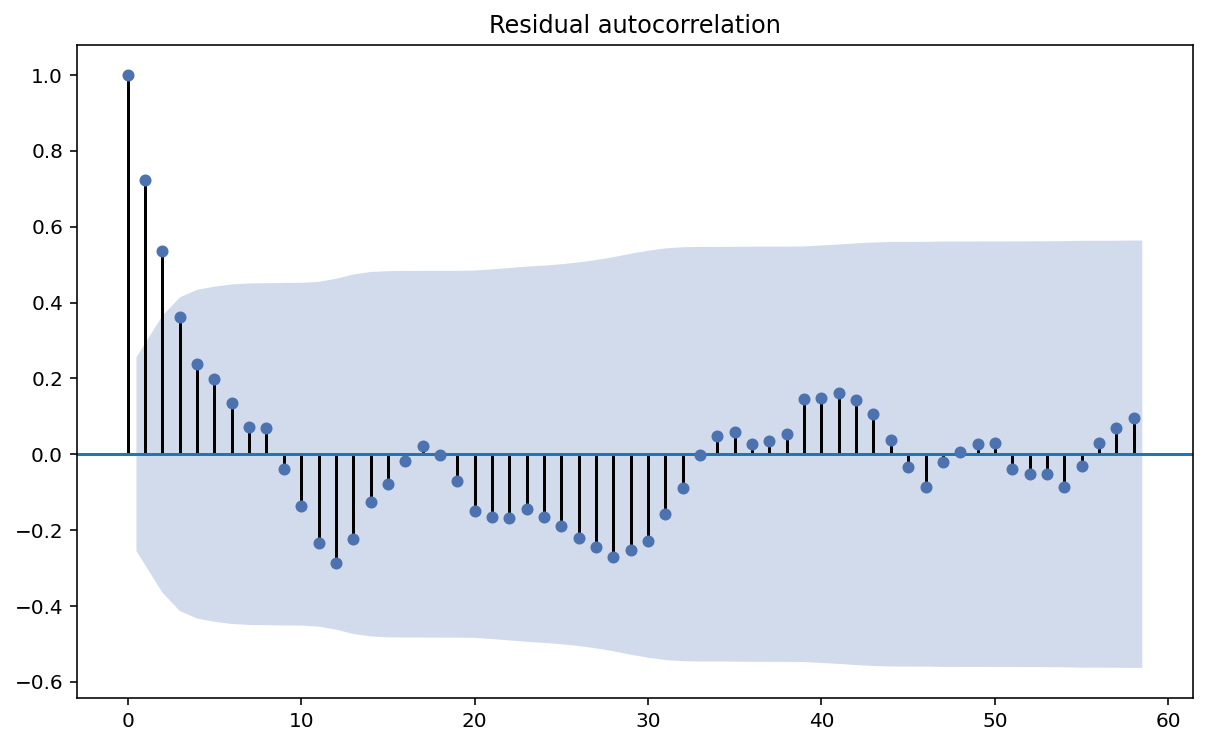

In [4]:
# AutoCorrelation Function (ACF Plot)
with plt.style.context('seaborn-deep'):
  plt.rc('figure', figsize = (10, 6))
  plot_acf(result.resid, lags = result.resid.shape[0] - 1, #-1 for not consider itself
           title = 'Residual autocorrelation')
plt.show()

##Durbin-Watson Test
*   If DW Statistic is closed to 0, the data are positive autocorrelation. 
*   If DW Statistic is closed to 4, the data are negative autocorrelation.
*   If DW Statistic is equal to 2, the data are no autocorrelation.

In [5]:
# Durbin-Watson Test
DWTest = durbin_watson(result.resid)

# Result
lowerBound, upperBound = 1.5, 2.5

if lowerBound <= DWTest <= upperBound:
  print(f'No autocorrelation DW Statistic: {DWTest:.4f}')
else:
  print(f'Autocorrelation DW Statistic: {DWTest:.4f}')

Autocorrelation DW Statistic: 0.3237


##Ljung-Box test
*   H0: The data are independently distributed. (No autocorrelation)
*   H1: The data not are independently distributed. (Autocorrelation)

If p-value less than alpha (0.05) then the null hypothesis is rejected. It can be concluded that the data are autocorrelation.

In [6]:
# Ljung-Box Test
_, LBPValue = acorr_ljungbox(result.resid,
                             lags = result.resid.shape[0] - 1) #Maximum lags of residual without itself

# Result
alpha = 0.05

if np.where(LBPValue > alpha)[0].size == 0:
  print(f'Autocorrelation with max p-value: {np.max(LBPValue):.4f}')
else:
  print(f'No autocorrelation with min p-value: {np.min(LBPValue):.4f}')

Autocorrelation with max p-value: 0.0000
